#### 1.0 Setup

In [14]:
# pytorch
import torch
from torch import nn

# machine learning
import pandas as pd
import numpy as np

# scikit-learn (dataset)
import sklearn
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split

# file
from pathlib import Path
import requests

# visualization
import matplotlib.pyplot as plt

# device
device = "cpu"

# print(torch.__version__)
# print(np.__version__)

#### 2.0 Understand & Visualize Toy Dataset

torch.Size([960, 2])
torch.Size([240, 2])
torch.Size([960])
torch.Size([240])


Text(0, 0.5, 'feature 2')

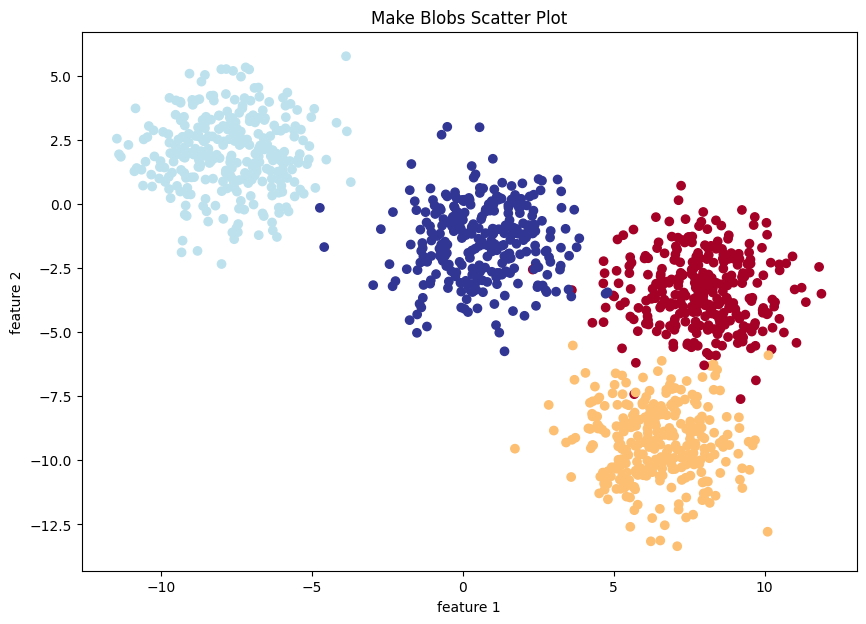

In [15]:
# 3D PLOT OF "MAKE_BLOBS" DATASET
"""
X, y = make_blobs(n_samples=1000, n_features=3, centers=4, cluster_std=1.5, random_state=11)

# Plot the dataset using matplotlib.pyplot
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=y)
ax.set_xlabel('Feature 1')
ax.set_ylabel('Feature 2')
ax.set_zlabel('Feature 3')
ax.set_title('Pyplot 3D Plot')
plt.show()
"""

# set hyperparameters
NUM_CLASSES = 4
NUM_FEATURES = 2 # 2D Graph
RANDOM_SEED = 6

X_blob, y_blob = make_blobs(n_samples=1200,
                  n_features=NUM_FEATURES,
                  centers=NUM_CLASSES,
                  cluster_std=1.5,
                  random_state=RANDOM_SEED)

"""
X_blob_num = pd.DataFrame({"X1": X[:, 0],
                         "X2": X[:, 1],
                         "label": y})
print(X_blob_num.head(20))
"""

# convert data to tensors
X = torch.from_numpy(X_blob).type(torch.float)
y = torch.from_numpy(y_blob).type(torch.LongTensor)

# split data
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    random_state=RANDOM_SEED)


# print(X_train.size())
# print(X_test.size())
# print(y_train.size())
# print(y_test.size())

# plot data
plt.figure(figsize=(10, 7))
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.RdYlBu)
plt.title('Make Blobs Scatter Plot')
plt.xlabel('feature 1') 
plt.ylabel('feature 2') 

#### 3.0 Setup Model & Hyperparameters

In [16]:
# build models
class BlobModel(nn.Module):
    def __init__(self, input_features, output_features, hidden_units=8):
        """
        Initializes multi-class classifiation model.

        Args:
            input_features (int): Number of input features to the model
            output_features (int): Number of output features
            hidden_units (int): Number of hidden layers between input and output, default 8
        """
        super().__init__()
        self.linear_layer_stack = nn.Sequential(
            nn.Linear(in_features=input_features, out_features=hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units, out_features=hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units, out_features=output_features)
        )

    def forward(self, x):
        """
        Forward pass of nn model.

        Args:
            x (torch.tensor): 
        """
        return self.linear_layer_stack(x)

# create model instance
model_ver_1 = BlobModel(input_features=2,
                        output_features=4,
                        hidden_units=8)

# model_ver_1

#### 5.0 Setup Loss Function & Optimizer

In [17]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model_ver_1.parameters(),
                            lr=0.1)

model_ver_1.eval()
with torch.inference_mode():
    y_logits_ex = model_ver_1(X_test.to(device))

y_pred_probs = torch.softmax(y_logits_ex, dim=1)
# print(y_pred_probs)
# print(torch.sum(y_pred_probs[0]))
# print(y_pred_probs[:5])
# print(y_pred_probs.size())
# print(y_pred_probs[0])
# print(torch.argmax(y_pred_probs[0]))

y_preds = torch.argmax(y_pred_probs, dim=1)
# print(y_preds)
# print(y_test)
# print(y_preds.size(), y_test.size())

#### 5.1 Import Accuracy Function

In [18]:
if Path("helper_functions.py").is_file():
    print("helper_functions.py already exists, skipping download")
else:
    print("Downloading helper_functions.py")
    # need raw url from github
    request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
    with open("helper_functions.py", "wb") as f:
        f.write(request.content)

from helper_functions import plot_decision_boundary, accuracy_fn

helper_functions.py already exists, skipping download


#### 6.0 Build Training & Testing Loop

In [19]:
torch.manual_seed(6)
epochs = 1000
X_train, X_test = X_train.to(device), X_test.to(device)
y_train, y_test = y_train.to(device), y_test.to(device)

for epoch in range(epochs):

    # set to training mode
    model_ver_1.train()

    # forward pass
    y_logits = model_ver_1.forward(X_train)

    # convert logits to probabilitiy to labels
    y_predictions = torch.softmax(y_logits, dim=1).argmax(dim=1)

    # calculate loss
    train_loss = loss_fn(y_logits, y_train)
    train_acc = accuracy_fn(y_true=y_train,
                            y_pred=y_predictions)

    # initialize optimizer
    optimizer.zero_grad()

    # backward propagation
    train_loss.backward()

    # update gradient value
    optimizer.step()

    # test
    model_ver_1.eval()
    with torch.inference_mode():
        test_logits = model_ver_1(X_test)
        test_predictions = torch.softmax(test_logits, dim=1).argmax(dim=1)
        test_loss = loss_fn(test_logits, y_test)
        test_acc = accuracy_fn(y_true=y_test,
                               y_pred=test_predictions)
        
    if epoch % 100 == 0:
        print(f"Epoch: {epoch} | Train Loss: {train_loss: .4f}, Train Acc: {train_acc: .2f}% | Test Loss: {test_loss : .4f}, Test Acc: {test_acc : .2f}%")

Epoch: 0 | Train Loss:  1.2571, Train Acc:  46.15% | Test Loss:  1.1361, Test Acc:  69.17%
Epoch: 100 | Train Loss:  0.1831, Train Acc:  96.46% | Test Loss:  0.2121, Test Acc:  95.42%
Epoch: 200 | Train Loss:  0.0890, Train Acc:  98.65% | Test Loss:  0.1237, Test Acc:  96.67%
Epoch: 300 | Train Loss:  0.0637, Train Acc:  98.85% | Test Loss:  0.0990, Test Acc:  97.08%
Epoch: 400 | Train Loss:  0.0535, Train Acc:  98.96% | Test Loss:  0.0887, Test Acc:  97.50%
Epoch: 500 | Train Loss:  0.0480, Train Acc:  98.85% | Test Loss:  0.0826, Test Acc:  97.50%
Epoch: 600 | Train Loss:  0.0444, Train Acc:  98.85% | Test Loss:  0.0781, Test Acc:  97.50%
Epoch: 700 | Train Loss:  0.0417, Train Acc:  98.85% | Test Loss:  0.0744, Test Acc:  97.92%
Epoch: 800 | Train Loss:  0.0396, Train Acc:  98.85% | Test Loss:  0.0714, Test Acc:  97.92%
Epoch: 900 | Train Loss:  0.0380, Train Acc:  98.85% | Test Loss:  0.0688, Test Acc:  97.92%


In [20]:
# print(y_logits.dtype, y_train.dtype)

#### 7.0 Visualize Results

In [21]:
# plot decision boundary of the model
"""
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_ver_1, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_ver_1, X_test, y_test)
"""

'\nplt.figure(figsize=(12, 6))\nplt.subplot(1, 2, 1)\nplt.title("Train")\nplot_decision_boundary(model_ver_1, X_train, y_train)\nplt.subplot(1, 2, 2)\nplt.title("Test")\nplot_decision_boundary(model_ver_1, X_test, y_test)\n'